<p style="font-family:Times New Roman; font-size:120%">
    -Aleksander Nistad Sekkelsten
</p>
<h1 style="font-family:Times New Roman; font-size: 300%"><center> Project 2 - Franke's funciton analysis </center></h1>

<p style="font-family:Times New Roman; font-size:120%">
    Here, I use feed forward neural networks with the optimization algorithms Gradient Descent, Stochastic Gradient Descent, Momentum, AdaGrad, RMSProp and ADAM on Franke's function. I compare various gradient calculation schemes, including analytical and zygote gradients. I also compare ridge and OLS regression for both. Lastly, I do some hyperparameter finetuning on SGD.
</p>

In [2]:
import Pkg; Pkg.activate(".julia/environments/v1.10/Project.toml")
Pkg.add(["SCS", "Convex","PlotThemes","Images"])
using Plots, Random, NBInclude, LinearAlgebra, Statistics, Distributions, Zygote, Flux, Optimisers
using Plots.PlotMeasures
using StatsBase: sample
theme(:dao)
@nbinclude("/Users/aleksandersekkelsten/Downloads/Project 1 function.ipynb")
@nbinclude("FYS-STK 4155 Project 2 Methods .ipynb")
@nbinclude("FYS-STK 4155 Project 2 FFNN.ipynb")

  Activating project at `~/.julia/environments/v1.10`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


ConfusionMatrix (generic function with 2 methods)

In [3]:
mse(z,ẑ) = sum((z .- ẑ).^2)/(length(z))

mse (generic function with 1 method)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Franke's function</h2>


In [4]:
#X and Y range
X = range(0,1,100) |> collect 
Y = range(0,1,100) |> collect

Random.seed!(123)
ϵ=Normal(0, 0.02) # Noise
#X and Y range
Z = Franke.(X',Y) .+ rand(ϵ,(100,100)) #Finding Z values

#Display Frankes funciton
surface(X,Y,Z, size=(1000,700),title="Franke's function")

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Manual training, Zygote Gradient</h2>


In [5]:

@Zygote.nograd function D(xData, yData, numDegrees)
    #Calculates the designmatrix without tracking the gradient with zygote
    exponents = [(i, j) for i in 0:numDegrees for j in 0:(numDegrees - i)]
    DesignMatrix = hcat([ (xData .^ i) .* (yData .^ j) for (i, j) in exponents ]...)
    return DesignMatrix
end

function loss_function(x_batch, layers, activation_funcs, y_batch)
    β_pred =feed_forward_batched(layers, x_batch, activation_functions;backprop=false) #Feed forward
    X_batch = D(x_batch[:, 1], x_batch[:, 2], 5) #Density matrix
    z_pred = sum(β_pred .* X_batch, dims=2)[:, 1]  # prediction
    
    mse_loss = mean((z_pred .- y_batch).^2)
    ridge_penalty = λ* mean(sum(β_pred.^2, dims=2)) 
    return mse_loss + ridge_penalty
end

loss_function (generic function with 1 method)

In [6]:
function train(X,Y,Z, layers, activation_funcs, learning_rate=0.01, epochs=1000; batch_size, optimizer, loss)
    xTrain, yTrain, zTrain, xTest, yTest, zTest = SplitData2D(X,Y,Z,0.8)
    Input = hcat(xTrain, yTrain) #train data
    inputt = hcat(xTest, yTest) #test data
    
    D_M_test = DataProjector(xTest, yTest, zTest, 5) #density matrix
    num_batches=Int(round(length(zTrain)/batch_size))
    batch_size=80
    
    #initializing standard parameters for each optimizer
    params = initialize(optimizer, layers, learning_rate, num_batches,batch_size;γ=0.9) 
    lossHistory = []
    
    for epoch in 1:epochs
        (layers, params) = optimizer(Input,zTrain, layers,  activation_funcs,loss, params)
        
        if epoch%100==0
            test_b = feed_forward_batched(layers, hcat(xTest, yTest),activation_functions)
            z_pred = sum(test_b .* D_M_test, dims=2)[:, 1]
            test_loss = mean((zTest .- z_pred).^2)
            println("Epoch:  ", epoch, "  Loss: ", test_loss)
            push!(lossHistory, test_loss)
        end
    end
    return layers, lossHistory
end

train (generic function with 3 methods)

In [7]:
linear(x) = x #Linear Activation function for no activation on the last layer

linear (generic function with 1 method)

In [8]:
#Hyperparameters
degrees=5
epochs = 500
batchSize = 80
η = 1e-3 #Learning rate
global λ=0 #1e-3 #Global in order to apply within functions, OLS=0, Ridge≠0
activation_functions = [sigmoid,linear] #Sigmoid activation on the hidden layer, linear (nothing) on the last
input_dimension = 2 #(x,y)
output_dimension = (degrees + 1) * (degrees + 2) ÷ 2 #Parameters for the polynomial

xGrid = repeat(X, inner=length(Y))
yGrid = repeat(Y, outer=length(X))
c = hcat(xGrid,yGrid)

DM = D(xGrid,yGrid, degrees)

10000×21 Matrix{Float64}:
 1.0  0.0        0.0          0.0          …  0.0       0.0  0.0       0.0
 1.0  0.010101   0.00010203   1.03061e-6      0.0       0.0  0.0       0.0
 1.0  0.020202   0.000408122  8.24488e-6      0.0       0.0  0.0       0.0
 1.0  0.030303   0.000918274  2.78265e-5      0.0       0.0  0.0       0.0
 1.0  0.040404   0.00163249   6.5959e-5       0.0       0.0  0.0       0.0
 1.0  0.0505051  0.00255076   0.000128826  …  0.0       0.0  0.0       0.0
 1.0  0.0606061  0.00367309   0.000222612     0.0       0.0  0.0       0.0
 1.0  0.0707071  0.00499949   0.000353499     0.0       0.0  0.0       0.0
 1.0  0.0808081  0.00652995   0.000527672     0.0       0.0  0.0       0.0
 1.0  0.0909091  0.00826446   0.000751315     0.0       0.0  0.0       0.0
 1.0  0.10101    0.010203     0.00103061   …  0.0       0.0  0.0       0.0
 1.0  0.111111   0.0123457    0.00137174      0.0       0.0  0.0       0.0
 1.0  0.121212   0.0146924    0.00178089      0.0       0.0  0.0       0.0

In [9]:
println(" ------  Training SGD  ------")
layers = create_layers_batch(input_dimension, [30, output_dimension])
layersSGD,lossSGD = train(X,Y,Z, layers, activation_functions, η, epochs; batch_size=batchSize, optimizer=SGD!, loss=loss_function)
β_SGD=feed_forward_batched(layersSGD, c, activation_functions;backprop=false)
z_SGD = sum(β_SGD .* DM, dims=2)[:, 1]

println(" ------  Training RMSProp  ------")
layers = create_layers_batch(input_dimension, [30, output_dimension])
layersRMSProp, lossRMSProp = train(X,Y,Z, layers, activation_functions, η, epochs; batch_size=batchSize, optimizer=RMSProp!, loss=loss_function)
β_RMSProp = feed_forward_batched(layersRMSProp, c, activation_functions;backprop=false)
z_RMSProp = sum(β_RMSProp .* DM, dims=2)[:, 1]

println(" ------  Training Momentum  ------")
layers = create_layers_batch(input_dimension, [30, output_dimension])
layersMomentum, lossMomentum = train(X,Y,Z, layers, activation_functions, η, epochs; batch_size=batchSize, optimizer=Momentum!, loss=loss_function)
β_Momentum = feed_forward_batched(layersMomentum, c, activation_functions;backprop=false)
z_Momentum = sum(β_Momentum .* DM, dims=2)[:, 1]

println(" ------  Training ADAGrad  ------")
layers = create_layers_batch(input_dimension, [30, output_dimension])
layersADAGrad,lossADAGrad = train(X,Y,Z, layers, activation_functions, 0.01, epochs; batch_size=batchSize, optimizer=AdaGrad!, loss=loss_function)
β_ADAGrad = feed_forward_batched(layersADAGrad, c, activation_functions;backprop=false)
z_ADAGrad = sum(β_ADAGrad .* DM, dims=2)[:, 1]

println(" ------  Training ADAM  ------")
layers = create_layers_batch(input_dimension, [30, output_dimension])
layersADAM, lossADAM = train(X,Y,Z, layers, activation_functions, 0.01, epochs; batch_size=batchSize, optimizer=ADAM!, loss=loss_function)
β_ADAM = feed_forward_batched(layersADAM, c, activation_functions;backprop=false)
z_ADAM = sum(β_ADAM .* DM, dims=2)[:, 1]


 ------  Training SGD  ------
Epoch:  100  Loss: 0.014398124728068893
Epoch:  200  Loss: 0.012722250443109814
Epoch:  300  Loss: 0.011734110600643444
Epoch:  400  Loss: 0.011109941638619376
Epoch:  500  Loss: 0.010697109786158801
 ------  Training RMSProp  ------
Epoch:  100  Loss: 0.009726309686688932
Epoch:  200  Loss: 0.013006556406540774
Epoch:  300  Loss: 0.004616267572299945
Epoch:  400  Loss: 0.007568657988953374
Epoch:  500  Loss: 0.0029007341946502914
 ------  Training Momentum  ------
Epoch:  100  Loss: 0.010395382627500465
Epoch:  200  Loss: 0.009794882476030446
Epoch:  300  Loss: 0.009355038724376001
Epoch:  400  Loss: 0.008978516668373508
Epoch:  500  Loss: 0.008648506387050862
 ------  Training ADAGrad  ------
Epoch:  100  Loss: 0.009752179658864853
Epoch:  200  Loss: 0.008871668108097076
Epoch:  300  Loss: 0.00830331893796712
Epoch:  400  Loss: 0.007879940542558667
Epoch:  500  Loss: 0.007543759178771991
 ------  Training ADAM  ------
Epoch:  100  Loss: 0.002183623275476

10000-element Vector{Float64}:
 0.7475273193644659
 0.7464038905204784
 0.744773165322804
 0.742618514202309
 0.7399141315525236
 0.736626148477868
 0.7327139265849502
 0.7281315311779819
 0.7228293751550242
 0.7167560155617982
 0.7098600735686986
 0.7020922362891913
 0.6934072863622175
 ⋮
 0.031272236188616076
 0.031373447268345234
 0.03137204173581426
 0.031263245538513174
 0.031043550214582882
 0.030710704459884774
 0.030263709296589614
 0.029702817283466076
 0.029029536130910305
 0.028246637018254694
 0.02735816785555406
 0.02636947168542686

In [10]:
s = surface(X,Y,layout = (3,2), reshape(Z, (100,100)), cbar=false, title="Franke's function",size=(1000,1200),titlefontsize=20)
surface!(s,X,Y,subplot=2, reshape(z_SGD, (100,100)), cbar=false, title="SGD",titlefontsize=20)
surface!(s,X,Y,subplot=3, reshape(z_Momentum, (100,100)), cbar=false, title="Momentum",titlefontsize=20)
surface!(s,X,Y,subplot=4, reshape(z_ADAGrad, (100,100)), cbar=false, title="ADAGrad",titlefontsize=20)
surface!(s,X,Y,subplot=5, reshape(z_RMSProp, (100,100)), cbar=false, title="RMSProp",titlefontsize=20)
surface!(s,X,Y,subplot=6, reshape(z_ADAM, (100,100)), cbar=false, title="ADAM",titlefontsize=20)
display(s)

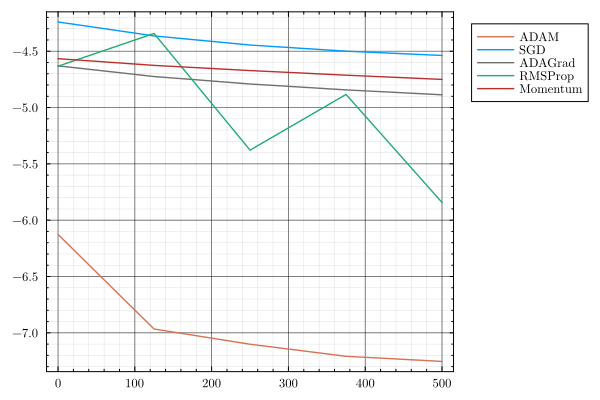

In [11]:
EpochHistory = range(0,epochs, length(lossSGD))
plot(EpochHistory, log.(lossADAM), label = "ADAM")
plot!(EpochHistory, log.(lossSGD), label="SGD")
plot!(EpochHistory, log.(lossADAGrad), label="ADAGrad")
plot!(EpochHistory, log.(lossRMSProp), label="RMSProp")
plot!(EpochHistory, log.(lossMomentum), label="Momentum")

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Flux training</h2>


In [12]:
input_dimension = 2
output_dimension = (degrees + 1) * (degrees + 2) ÷ 2

xTrain, yTrain, zTrain, xTest, yTest, zTest = SplitData2D(X, Y, Z, 0.8)
it = vcat(xTest', yTest')
I = vcat(xTrain', yTrain')

# Prepare data batches
num_batches = Int(floor(length(zTrain) / batchSize))
data = []

for i in 1:num_batches
    a = batchSize * (i - 1) + 1
    b = batchSize * i
    input_batch = I[:, a:b]
    label_batch = zTrain[a:b]
    push!(data, (input_batch, label_batch))
end

# Handle any remaining data
if batchSize * num_batches < length(zTrain)
    a = batchSize * num_batches + 1
    input_batch = I[:, a:end]
    label_batch = zTrain[a:end]
    push!(data, (input_batch, label_batch))
end

In [13]:
model = Chain(
    Dense(input_dimension, 30, sigmoid),
    Dense(30, output_dimension)
)

opt = Flux.setup(Optimisers.Adam(1e-3), model)

(layers = ((weight = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 2.22045e-16), (Float32[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], Float32[0.0 0.0; 0.0 0.0; … ; 0.0 0.0; 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 2.22045e-16), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 2.22045e-16), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.001, (0.9, 0.999), 2.22045e-16), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 

In [14]:
function Lossflux(model, input, target)
    #input = x, y
    β_pred = model(input)
    X_batch = D(input[1, :], input[2, :], degrees)
    z_pred = sum(β_pred .* X_batch', dims=1)[1, :]
    mse_loss = mean((z_pred - target).^2)
    return mse_loss
end

Lossflux (generic function with 1 method)

In [15]:
for epoch in 1:epochs
    for batch in data
        input, target = data
        Flux.train!(Lossflux, model, [input, target], opt)
    end

    if epoch % 100 == 0
        test_loss = Lossflux(model,it, zTest)
        println("Epoch $epoch, Test Loss: $test_loss")
    end
end


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(2 => 30, σ)   # 90 parameters
│   summary(x) = "2×80 Matrix{Float64}"
└ @ Flux ~/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


Epoch 100, Test Loss: 0.004321054151222016
Epoch 200, Test Loss: 0.001960241422659789
Epoch 300, Test Loss: 0.0017524088674250836
Epoch 400, Test Loss: 0.0019710784070026584
Epoch 500, Test Loss: 0.00249775584168918


0.0027148497851758866


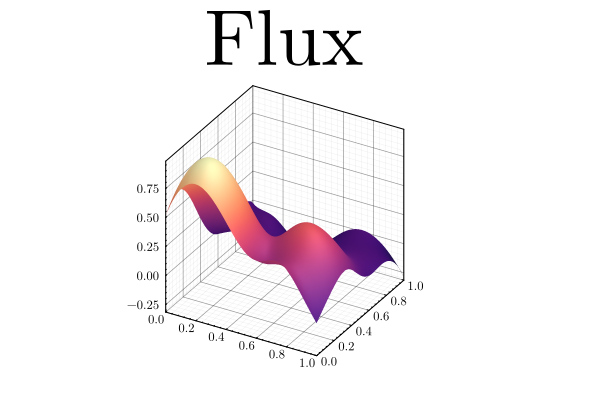

In [16]:
xGrid = repeat(X, inner=length(Y))
yGrid = repeat(Y, outer=length(X))
c = vcat(xGrid',yGrid')

DM = D(xGrid,yGrid, degrees)

β_flux = model(c)
z_flux = sum(β_flux' .* DM, dims=2)#[:, 1]

println(mse(reshape(Z,length(Z),1),z_flux))
surface(X,Y,reshape(z_flux,(100,100)), title="Flux",titlefontsize=50,cbar=false)

<h2 style="font-family:Times New Roman; font-weight:bolder; font-size:240%">Hyperparameter tuning</h2>


In [17]:
function loss_function(x_batch, layers, activation_funcs, y_batch)
    β_pred =feed_forward_batched(layers, x_batch, activation_functions;backprop=false)
    X_batch = D(x_batch[:, 1], x_batch[:, 2], 5)
    z_pred = sum(β_pred .* X_batch, dims=2)[:, 1]  # Resulting in a vector of size (batch_size,)
    mse_loss = mean((z_pred .- y_batch).^2)
    ridge_penalty = λ* mean(sum(β_pred.^2, dims=2)) #λ
    return mse_loss + ridge_penalty
end

loss_function (generic function with 1 method)

In [18]:
xGrid = repeat(X, inner=length(Y))
yGrid = repeat(Y, outer=length(X))
c = hcat(xGrid,yGrid)

η_vals = [ 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # learning rates
λ_vals = [0, 1e-4, 1e-3, 1e-2, 1e-1,1] # Ridge penalty coefficients

MSE_vals = zeros(length(η_vals), length(λ_vals))
    
for (λ_idx, λ_val) in enumerate(λ_vals)
    for (η_idx, η_val) in enumerate(η_vals)

        global λ = λ_val
        layers = create_layers_batch(input_dimension, [30, output_dimension])
        layersADAM, lossADAM = train(X,Y,Z, layers, activation_functions, η_val, epochs; batch_size=batchSize, optimizer=ADAM!, loss=loss_function)
        β_ADAM = feed_forward_batched(layersADAM, c, activation_functions;backprop=false)
        z_ADAM = sum(β_ADAM .* DM, dims=2)[:, 1]

        MSE_vals[η_idx,λ_idx] = mse(z_ADAM, reshape(Z,length(Z)))
        
    end
end

Epoch:  100  Loss: 0.4021314459708501
Epoch:  200  Loss: 0.3572307240033812
Epoch:  300  Loss: 0.3221056917157764
Epoch:  400  Loss: 0.292262247720122
Epoch:  500  Loss: 0.26596030951503974
Epoch:  100  Loss: 0.5187866268338303
Epoch:  200  Loss: 0.1228207937032837
Epoch:  300  Loss: 0.07592466931110776
Epoch:  400  Loss: 0.054443330820775473
Epoch:  500  Loss: 0.039863895310660105
Epoch:  100  Loss: 0.019716039520336685
Epoch:  200  Loss: 0.01038114384590353
Epoch:  300  Loss: 0.009781092827933466
Epoch:  400  Loss: 0.009467838683071434
Epoch:  500  Loss: 0.009223755868157688
Epoch:  100  Loss: 0.010080861458892941
Epoch:  200  Loss: 0.008629921428392596
Epoch:  300  Loss: 0.007682510827398048
Epoch:  400  Loss: 0.006978924866141412
Epoch:  500  Loss: 0.006438946740888484
Epoch:  100  Loss: 0.006157517397888137
Epoch:  200  Loss: 0.004204817273592616
Epoch:  300  Loss: 0.0028141641129633193
Epoch:  400  Loss: 0.002294654562274294
Epoch:  500  Loss: 0.0021436733915804894
Epoch:  100  L

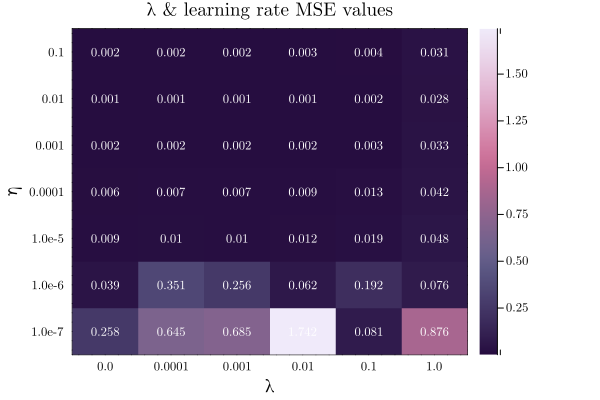

In [19]:
hb = heatmap(MSE_vals, cmap=:acton,title="λ & learning rate MSE values", yticks=(1:7, η_vals), xticks=(1:7, λ_vals), ylabel="η",xlabel="λ")
annotate!(hb,[(j, i, text(round(MSE_vals[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(η_vals) for j in 1:length(λ_vals)])
hb

In [20]:
global λ=0.001
η = 0.001
n = 8000 #Length of xTrain data
batch_sizes = Int.([n/1000, n/500, n/100, n/50, n/10, n/5, n/2])
epoch_vals = [5, 20, 50, 100, 300, 1000]
MSE_vals2 = zeros(length(batch_sizes), length(epoch_vals))
    
    
for (B_idx, B_val) in enumerate(batch_sizes)
    for (E_idx, E_val) in enumerate(epoch_vals)
        layers = create_layers_batch(input_dimension, [30, output_dimension])
        layersADAM, lossADAM = train(X,Y,Z, layers, activation_functions, 1e-3, E_val; batch_size=B_val, optimizer=ADAM!, loss=loss_function)
        β_ADAM = feed_forward_batched(layersADAM, c, activation_functions;backprop=false)
        z_ADAM = sum(β_ADAM .* DM, dims=2)[:, 1]

        MSE_vals2[B_idx,E_idx] = mse(z_ADAM, reshape(Z,length(Z)))
        
    end
end

Epoch:  100  Loss: 0.018261113976562056
Epoch:  100  Loss: 0.027221520942466562
Epoch:  200  Loss: 0.0028819639279605244
Epoch:  300  Loss: 0.002065378300033541
Epoch:  100  Loss: 0.020760844665641404
Epoch:  200  Loss: 0.008335256525079361
Epoch:  300  Loss: 0.007011849137955094
Epoch:  400  Loss: 0.004858198885466486
Epoch:  500  Loss: 0.0036091343026447603
Epoch:  600  Loss: 0.0031161673845962997
Epoch:  700  Loss: 0.002851889162747974
Epoch:  800  Loss: 0.002424380252990745
Epoch:  900  Loss: 0.0016170458632818634
Epoch:  1000  Loss: 0.001066375874172836
Epoch:  100  Loss: 0.02159993963141276
Epoch:  100  Loss: 0.02188973275529076
Epoch:  200  Loss: 0.010709622347538904
Epoch:  300  Loss: 0.00904669488107032
Epoch:  100  Loss: 0.006299104037622421
Epoch:  200  Loss: 0.004266064668238509
Epoch:  300  Loss: 0.05244460343991292
Epoch:  400  Loss: 0.0017626195148254464
Epoch:  500  Loss: 0.00449923681468584
Epoch:  600  Loss: 0.001666011512225023
Epoch:  700  Loss: 0.001784706148902553

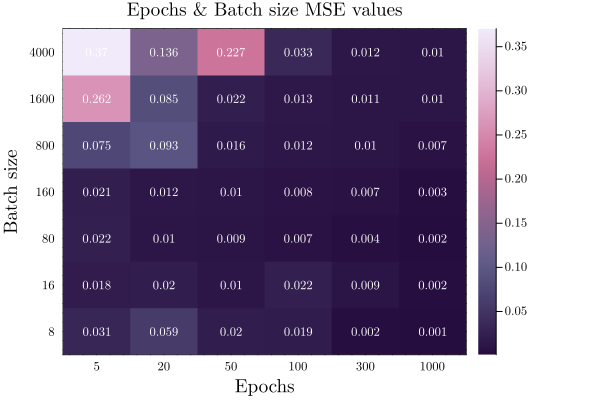

In [21]:
hb = heatmap(MSE_vals2, cmap=:acton,title="Epochs & Batch size MSE values", yticks=(1:length(batch_sizes), batch_sizes), xticks=(1:length(epoch_vals), epoch_vals), ylabel="Batch size",xlabel="Epochs")
annotate!(hb,[(j, i, text(round(MSE_vals2[i,j],digits=3), 8,"Computer Modern",:white)) for i in 1:length(batch_sizes) for j in 1:length(epoch_vals)])
hb